In [206]:
import jax.numpy as jnp
import jax
import numpy as np

%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

In [207]:
pauli_x = [[0., 1.], [1., 0.]]
pauli_y = [[0., -1.j], [1.j, 0.]]
pauli_z = [[1., 0.], [0., -1.]]

pauli = jnp.asarray([pauli_x, pauli_y, pauli_z])

basis = jnp.asarray([
    [[1, 0], [0, 0]],
    [[0, 1], [0, 0]],
    [[0, 0], [1, 0]],
    [[0, 0], [0, 1]],
])

In [220]:
# Determininstic evolution
omega0 = 1
hamiltonian_0 = -0.5*omega0*pauli[2]

# Noisy evolution
gamma = 0.05
#theta, phi = 0., 0.
#n = jnp.asarray([jnp.cos(phi)*jnp.sin(theta), jnp.sin(phi)*jnp.sin(theta), jnp.cos(theta)])
n = jnp.asarray([1, 1, 1])
kraus = jnp.sqrt(gamma) * jnp.einsum('a, aij -> aij', n, pauli)


In [221]:
def matrix2coords(matrix, basis):
    return jnp.einsum('ij, aji -> a', matrix, basis)

def coords2matrix(coords, basis):
    return jnp.einsum('a, aij -> ij', coords, basis)

In [222]:
def gram_matrix(operator, mu, nu):
    mapx1 = jax.vmap(lambda mu, nu: operator(mu, nu), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda mu, nu: mapx1(mu, nu), in_axes=(None, 0), out_axes=1)
    return mapx2(mu, nu)


def lindbladian_coords(hamiltonian, kraus, basis):
    
    def lindbladian(mu, nu):
        Lt = -1.j*(hamiltonian @ nu - nu @ hamiltonian)
        for k in kraus:
            Lt += k @ (nu @ jnp.conjugate(k.T)) - 0.5*((jnp.conjugate(k.T)@k)@nu + (jnp.conjugate(k.T)@k)@nu)
        return jnp.trace(mu.T @ Lt)
    
    return gram_matrix(lindbladian, basis, basis)

    

In [223]:
# Initial conditions
s0 = jnp.asarray([0, 0, 1])
rho0 = 0.5 * (jnp.eye(2) + jnp.einsum('a, aij -> ij', s0, pauli))
rho0_coords = matrix2coords(rho0, basis)

# Set-up simulation
times = jnp.linspace(0, jnp.pi*2, 501)
rhos_coords = [rho0_coords]

# Run simulation
for idx in range(1, len(times)):
    rho_old = rhos_coords[-1]
    t = times[idx]
    dt = times[idx] - times[idx-1]

    # Control
    if t <= 1 or t>=3:
        control_impulse = 0 * jnp.asarray([1, 0, 0])
    else:
        control_impulse = 4 * jnp.asarray([1, 0, 0])

    
    hamiltonian_control = jnp.einsum('a, aij -> ij', control_impulse, pauli)

    hamiltonian_ = hamiltonian_0 + hamiltonian_control

    lindbladian_t = lindbladian_coords(hamiltonian_, kraus, basis)
    rho_new = jax.scipy.linalg.expm(lindbladian_t * dt) @ rho_old
    
    rhos_coords.append(rho_new)

In [224]:
# Calculate some stuff

rhos = [coords2matrix(x, basis) for x in rhos_coords]
purity = [jnp.trace(x @ jnp.conjugate(x.T)) for x in rhos]

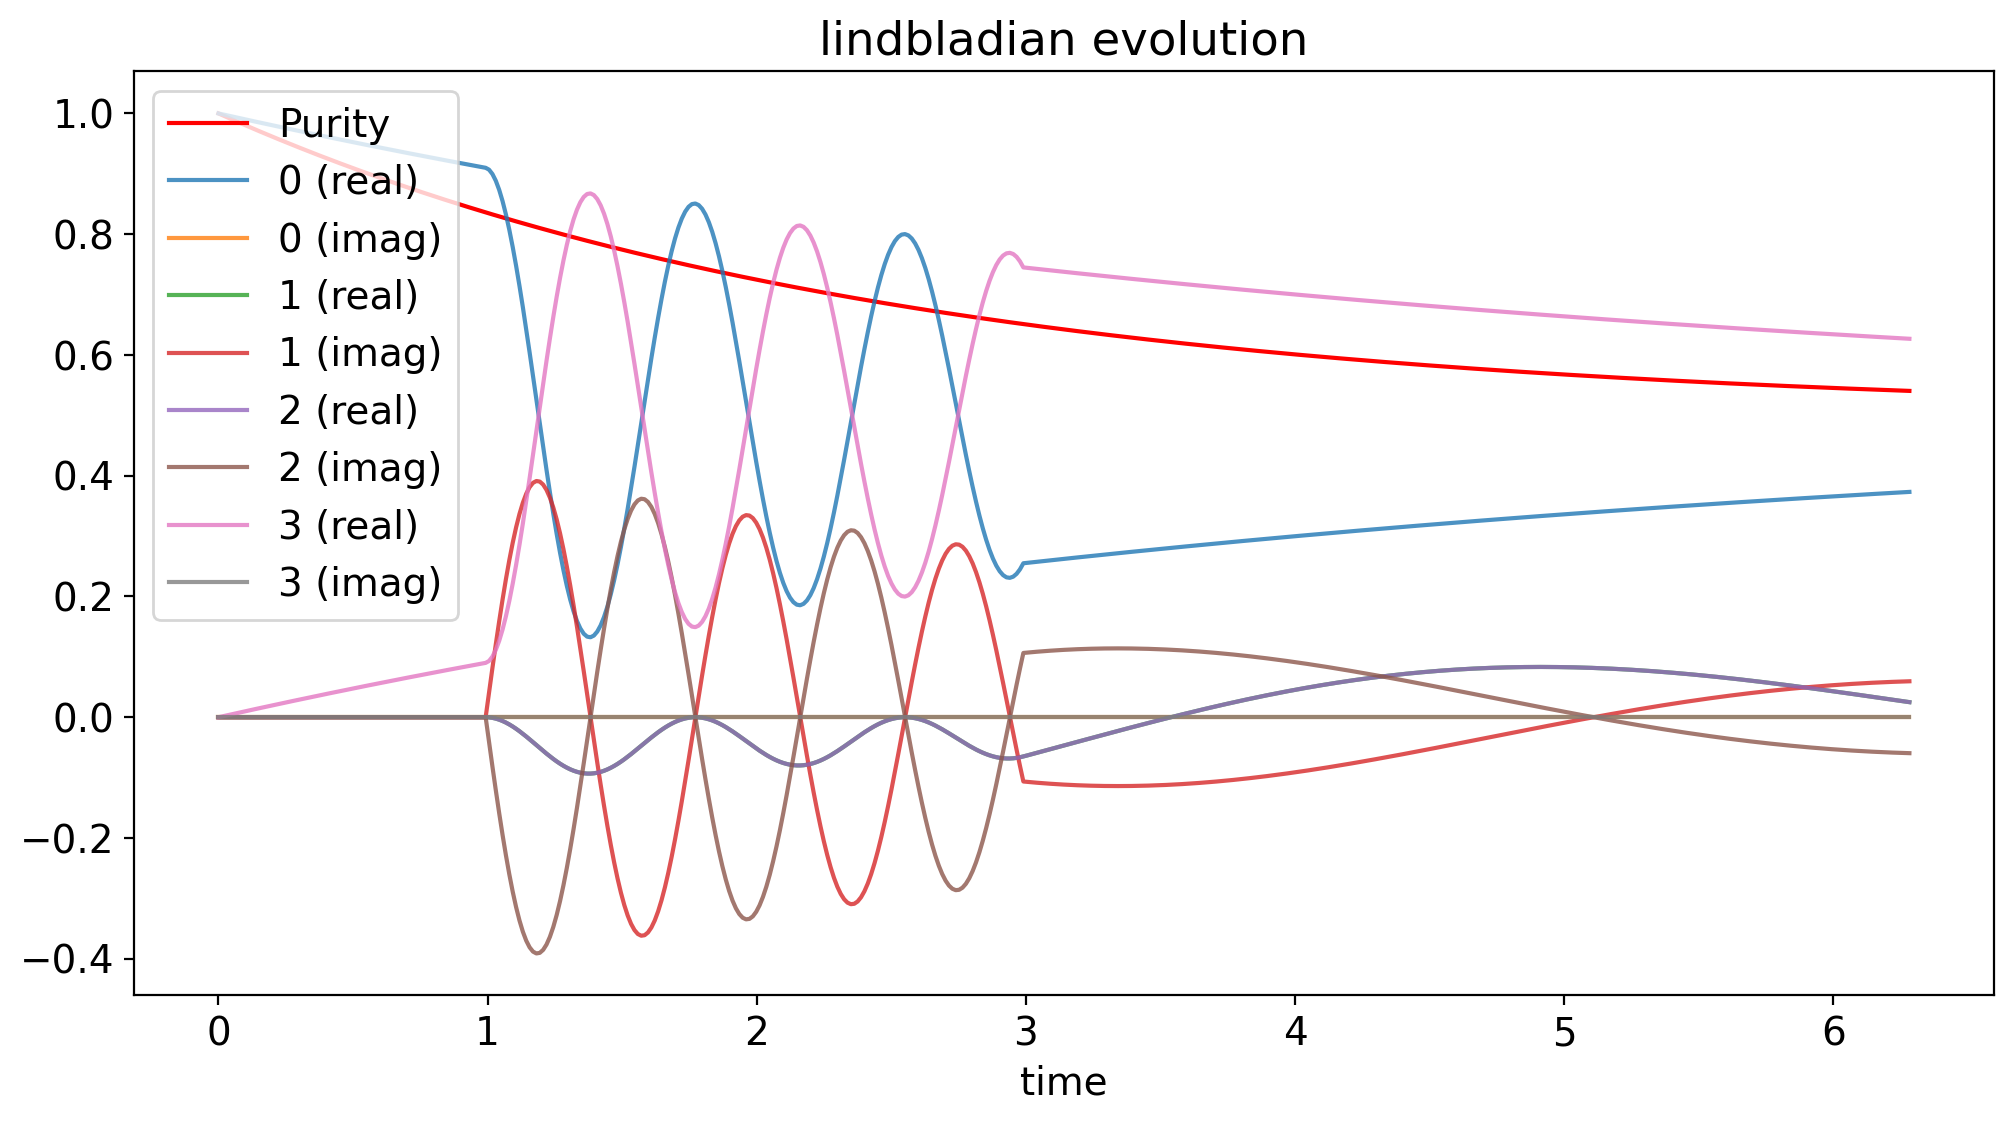

In [225]:
# Plot data
plt.figure(figsize=(12,6))
plt.plot(times, purity, color="r", alpha=1, label='Purity', zorder=1)

for idx in range(4):
    plt.plot(times, jnp.real(jnp.asarray(rhos_coords)[:,idx]), alpha=0.8, label='{} (real)'.format(idx), zorder=1)
    plt.plot(times, jnp.imag(jnp.asarray(rhos_coords)[:,idx]), alpha=0.8, label='{} (imag)'.format(idx), zorder=1)

plt.xlabel('time')
plt.title('lindbladian evolution')
plt.legend()
plt.show()